In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, inspect, func, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a SQLAlchemy base using `automap_base()` to automatically generate my Python classes from my Postgresql DB tables
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
inspector = inspect(engine)
session = Session(bind=engine)
#allows me to use python to query table

#understand what's written in each table
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date).first()


('2010-01-01',)

('2017-08-23',)
2016-08-23 00:00:00


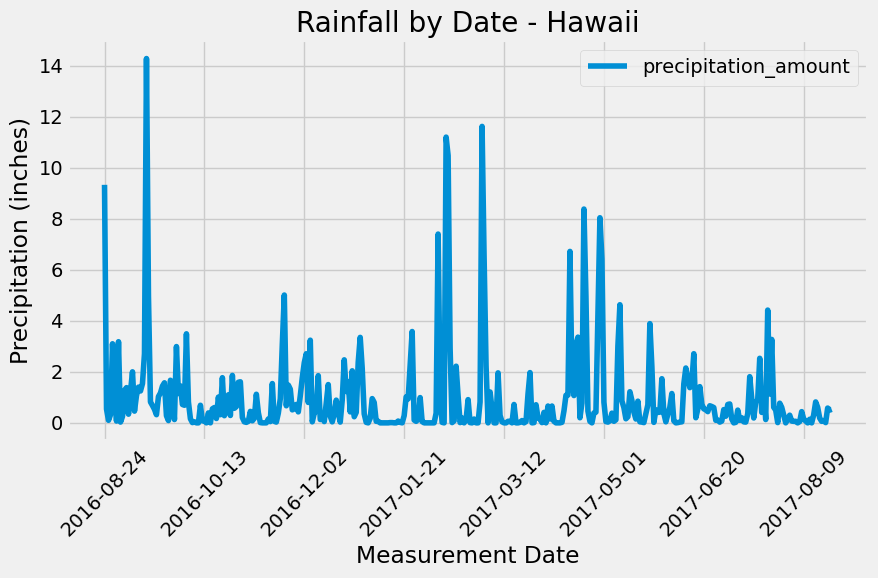

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
# Calculate the date one year from the last date in data set.
ONE_YR_PRIOR  = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = ONE_YR_PRIOR - dt.timedelta(days=365)
print(start_date)
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column, 
# Sort the dataframe by date
hawaii_prcp_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
hawaii_prcp_df.dropna(axis=0, how='any', inplace= True)
hawaii_prcp_df.sort_values(by='measurement_date')
hawaii_prcp_df.set_index('measurement_date', inplace=True)
hawaii_prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
ax = hawaii_prcp_df.plot(rot=45, title = "Rainfall by Date - Hawaii", 
                           xlabel='Measurement Date',
                           ylabel = "Precipitation (inches)", 
                           figsize=(9,6))
# precipitation_df.plot(rot=45)
plt.tight_layout()
plt.show()
ax.figure.savefig('2016_2017_PRCP_Hawaii.png', bbox_inches='tight')



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_prcp_df.describe()

,precipitation_amount
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
select = [Measurement.station, 
       func.count(Measurement.date)]
most_active_stations = session.query(*select).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query,
# calculate the lowest, highest, and average temperature.
select = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temps_l_h_avg = session.query(*select).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temps_l_h_avg:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


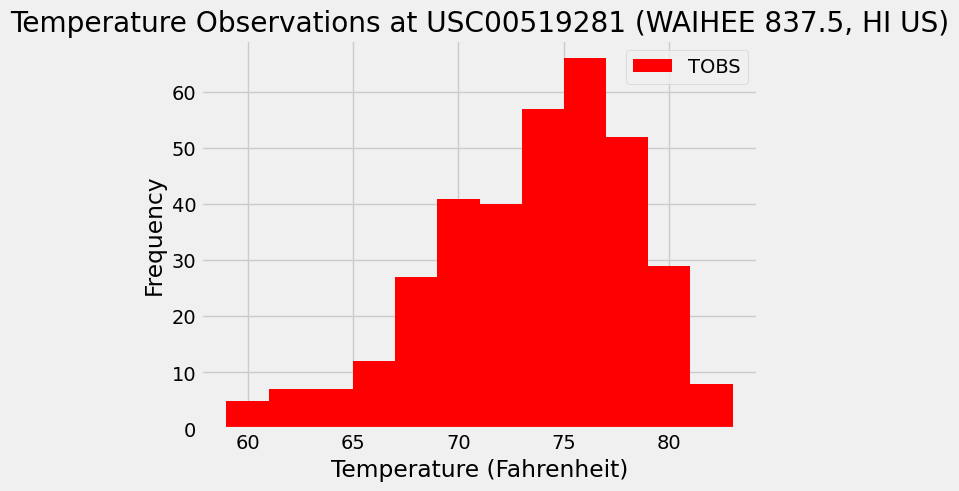

In [22]:
plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS", color='red')
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281 (WAIHEE 837.5, HI US)")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

# Close session

In [17]:
# Close Session
session.close()